# Лабораторная работа 9

In [1]:
import numpy as np
from sklearn.datasets import load_iris 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Алгоритм Брона-Кeрбоша

In [2]:
def bron_kerbosch_max_by_inclusion(m):

    results = []

    def check(K, P):
        for i in P:
            q = True
            for j in K:
                if m[i][j]:
                    q = False
                    break
            if q: return False
        return True

    def extend(M, K, P):

        while K and check(K, P):

            v = K[0]
            M.append(v)

            new_K = [ i for i in K if not m[i][v] and i != v ]
            new_P = [ i for i in P if not m[i][v] and i != v ]

            if not new_K and not new_P:
                results.append(list(M))
            else:
                extend(M, new_K, new_P)

            K.remove(v)
            M.remove(v)
            P.append(v)

    def inverse(m):
        for i in range(len(m)):
            for j in range(len(m)):
                if m[i, j]:
                    m[i, j] = 0
                else:
                    m[i, j] = 1
        return m
    
    m = inverse(m)
    extend([], list(range(len(m))), [])
    max_size = 0
    max_click = []
    for i in results:
        if len(i) > max_size:
            max_size = len(i)
            max_click = i
    return [i + 1 for i in max_click]

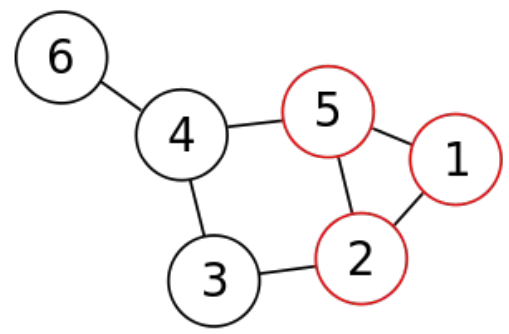

In [3]:
A = np.array([[0, 1, 0, 0, 1, 0],
             [1, 0, 1, 0, 1, 0],
             [0, 1, 0, 1, 0, 0],
             [0, 0, 1, 0, 1, 1],
             [1, 1, 0, 1, 0, 1],
             [0, 0, 0, 1, 0, 0]])
print(bron_kerbosch_max_by_inclusion(A))


[1, 2, 5]


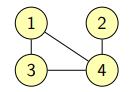

In [4]:

A = np.array([[0, 0, 1, 1],
              [0, 0, 0, 1],
              [1, 0, 0, 1],
              [1, 1, 1, 0]])

print(bron_kerbosch_max_by_inclusion(A))

[1, 3, 4]


Cлучайный лес

In [5]:
class DesicionTree:
    def __init__(self, max_depth=None, min_samples_to_split=2):
        self.max_depth = max_depth
        self.min_sample_to_split = min_samples_to_split
        self.split_feature = None
        self.split_value = None
        self.left_child = None
        self.right_child = None
        self.label = None
    
    def gini(self, y):
        _, c = np.unique(y, return_counts=True)
        return 1 - np.sum((c / len(y)) ** 2)


    def fit(self, x, y):
        if not self.max_depth:
            self.max_depth = x.shape[1]
        
        if x.shape[0] < self.min_sample_to_split or self.max_depth == 0 or len(np.unique(y)) == 1:
            self.label = np.bincount(y).argmax()
            return
        
        best_feature = None
        best_value = None
        best_score = np.inf

        for f in range(x.shape[1]):
            for v in np.unique(x[:, f]):
                left = y[x[:, f] < v]
                right = y[x[:, f] >= v]
                if len(left) == 0 or len(right) == 0:
                    continue
                score = (len(left) * self.gini(left) + len(right) * self.gini(right)) / len(y)
                if score < best_score:
                    best_score = score
                    best_feature = f
                    best_value = v
        
        self.split_feature = best_feature
        self.split_value = best_value

        self.left_child = DesicionTree(max_depth=self.max_depth-1, min_samples_to_split=self.min_sample_to_split)
        self.right_child = DesicionTree(max_depth=self.max_depth-1, min_samples_to_split=self.min_sample_to_split)
        self.left_child.fit(x[x[:, best_feature] < best_value], y[x[:, best_feature] < best_value])
        self.right_child.fit(x[x[:, best_feature] >= best_value], y[x[:, best_feature] >= best_value])

    def predict(self, x):
        if self.label is not None:
            return np.array([self.label] * x.shape[0])
        else:
            y = np.zeros(x.shape[0])
            y[x[:, self.split_feature] < self.split_value] = self.left_child.predict(x[x[:, self.split_feature] < self.split_value])
            y[x[:, self.split_feature] >= self.split_value] = self.right_child.predict(x[x[:, self.split_feature] >= self.split_value])
            return y.astype(int)
    

In [6]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_saples_to_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_to_split = min_saples_to_split
        self.max_features = max_features
        self.trees = []

    def fit(self, x, y):
        if self.max_features is None:
            self.max_features = int(np.sqrt(x.shape[1]))
        for i in range(self.n_estimators):
            sample_ind = np.random.choice(x.shape[0], x.shape[0])
            feature_ind = np.random.choice(x.shape[1], self.max_features, replace=False)
            tree = DesicionTree(max_depth=self.max_depth, min_samples_to_split=self.min_samples_to_split)
            tree.fit(x[sample_ind][:, feature_ind], y[sample_ind])
            self.trees.append(tree)
        
    def predict(self, x):
        y_pred = np.zeros(x.shape[0])
        for t in self.trees:
            y_pred += t.predict(x[:, np.random.choice(x.shape[1], self.max_features, replace=False)]) / self.n_estimators
        if (y_pred <=1).all():
            return y_pred.round()
        
        y_pred = np.where(y_pred < 1, y_pred, y_pred.round())
        return y_pred.astype(int)

In [37]:
x, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

f = RandomForest(n_estimators=100, max_depth=10, max_features=3)
f.fit(x_train, y_train)
y_pred = f.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(round(acc, 2))

0.8


In [39]:
x, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

tree = DesicionTree(max_depth=10, min_samples_to_split=2)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(round(acc, 2))
print(y_test)
print(y_pred)

0.97
[2 2 2 1 2 2 0 2 2 1 2 0 1 2 1 0 1 1 2 1 2 1 1 0 1 2 2 2 2 0]
[2 2 2 1 2 2 0 2 2 1 2 0 1 2 1 0 1 2 2 1 2 1 1 0 1 2 2 2 2 0]
